# Loads maps and and crops them to the same size

In [20]:
import os
import numpy as np
import scipy
import matplotlib.pyplot as plt
import copy
plt.style.use('seaborn-notebook')

In [21]:
from MADLens.util import *

In [22]:
run_dir   = '../runs'
githashes = os.listdir(run_dir)
for githash in githashes:
    print(githash)
    path = os.path.join(run_dir,githash)
    print(os.listdir(path))

2120673
['small_run.json', 'test_run_20.json', 'small_run_0.json', 'test_run_40.json', 'test_run_00.json', 'small_run_10.json', 'small_run_00.json', 'test_run_30.json', 'test_run_10.json']
b2f7b0b
['test_run_20.json', 'test_run_40.json', 'test_run_00.json', 'test_run_30.json', 'test_run_10.json']
eba3a69
['test_run_20.json', 'test_run_40.json', 'test_run_00.json', 'test_run_30.json', 'test_run_10.json']
de321bb
['small_run.json']
43458b5
['small_run.json']
106b3db
['small_run.json']
f05cdbe
['test_run_20.json', 'test_run_40.json', 'test_run_00.json', 'test_run_30.json', 'test_run_10.json']
ec8628e
['test_run_00.json']
7c44cd7
['highres0.json']
9a9d190
['test_run_20.json', 'test_run_40.json', 'test_run_00.json', 'test_run_30.json', 'test_run_10.json']
e0d2dc0
['small_run.json']
ea1d8fd
['test_run_01.json', 'test_run_00.json']
6252a18
['small_run.json']


In [25]:
fov_min,fov_max,Omega_ms,sigma8s, _, _ = pickle.load(open(os.path.join('../run_specs','S_8_small_run.pkl'),'rb'))
param_path  = '/global/homes/v/vboehm/codes/MADLens/runs/'
git_hash    = 'de321bb'
label       = 'small_run'

In [26]:
params_file = os.path.join(param_path,git_hash,label+'.json')
with open(params_file, 'r') as f:
    params = json.load(f)
map_dir = os.path.join(params['results_path'],'maps',params['label'])

In [29]:
BoxSize2D = [deg/180.*np.pi for deg in params['BoxSize2D']]
pm2D      = ParticleMesh(BoxSize=BoxSize2D, Nmesh=params['Nmesh2D'],resampler='cic')

In [30]:
def lowpass_transfer(r):
    def filter(k, v):
        k2 = sum(ki ** 2 for ki in k)
        return np.exp(-0.5 * k2 * r**2) * v
    return filter

def get_fov(cosmo,BoxSize,z_source):
    """
    get the field of view (in degrees) for given boxsize and source redshift
    """
    chi_source = cosmo.angular_diameter_distance(z_source)*(1+z_source)
    fov        = BoxSize[0:2]/chi_source/np.pi*180.
    return fov

desired_fov = fov_min


def crop_map(mymap,desired_fov,desired_pixel_num,params,cosmo,zs=1):
    fov     = get_fov(cosmo,params['BoxSize'],z_source=zs)
    pix_size= fov/params['Nmesh2D']
    num_pix = np.cast['int32'](np.round((desired_fov/(pix_size))))
    new_pm  = ParticleMesh(BoxSize=[desired_fov/180.*np.pi]*2, Nmesh=num_pix)
    #old_map = old_map.r2c().apply(lowpass_transfer(pix_size[0]/180.*np.pi*2)).c2r()
    new_map = new_pm.create(type='real',value=mymap.value[:num_pix[0],:num_pix[0]])
    #new_map = new_map.r2c().apply(lowpass_transfer(pix_size[0]/180.*np.pi*2)).c2r()
    new_pm  = ParticleMesh(BoxSize=[desired_fov/180.*np.pi]*2, Nmesh=[desired_pixel_num]*2, resampler='cic')
    new_map = new_pm.downsample(new_map,resampler='cic',keep_mean=True)
    new_map = new_map.r2c().apply(lowpass_transfer(pix_size[0]/180.*np.pi*4.)).c2r()
    
    return new_map

In [31]:
my_cropped_maps =[]
for ii in range(len(Omega_ms))[0:10]:
    Omega_m   = Omega_ms[ii]
    sigma_8   = sigma8s[ii]
    cosmo     = Planck15.match(Omega0_m=Omega_m)
    cosmo     = cosmo.match(sigma8=sigma_8)
    map_file  = os.path.join(map_dir,'map_decon_zsource%d_cosmo%d'%(params['zs_source'][0]*10,ii)+'.npy')
    kappa_map = np.load(map_file).reshape(*pm2D.Nmesh)
    kappa_map = pm2D.create(type='real',value=kappa_map)
    my_cropped_maps+=[crop_map(kappa_map,desired_fov,1024,params,cosmo)]

Text(0.5, 0, 'L')

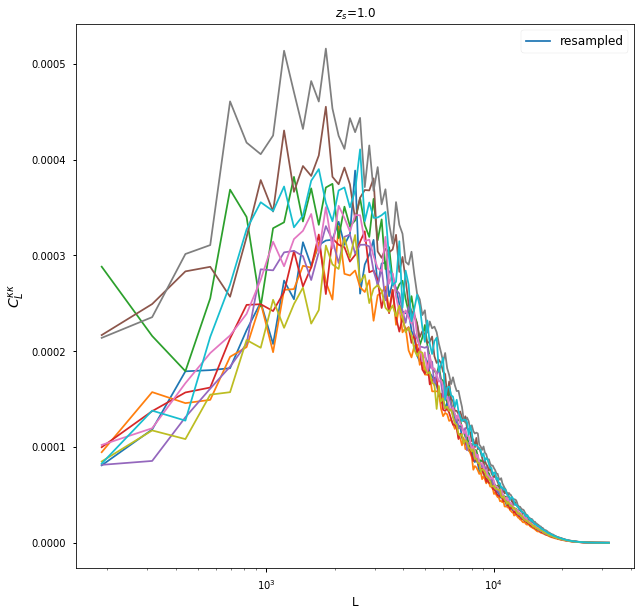

In [32]:
plt.figure(figsize=(10,10))
for jj in range(len(Omega_ms))[0:10]:
    plt.title('$z_s$=%.1f'%zs,fontsize=12)
    L, clkk, _= get_2Dpower(my_cropped_maps[jj])
    #p= plt.loglog(my_runs[jj].measured_cls[str(zs)]['L'],my_runs[jj].measured_cls[str(zs)]['L']**2*my_runs[jj].measured_cls[str(zs)]['clkk'],label='measured')
    #p = plt.semilogx(my_runs[jj].theory_cls[str(zs)]['L'],my_runs[jj].theory_cls[str(zs)]['L']**2*my_runs[jj].theory_cls[str(zs)]['clkk'])#,color=p[0].get_color(),ls='--',label='halofit')
    plt.semilogx(L,L**2*clkk,label='resampled')
    if jj==0:
        plt.legend(fontsize=12)
plt.ylabel('$C_L^{\kappa \kappa}$',fontsize=14)
plt.xlabel('L',fontsize=12)

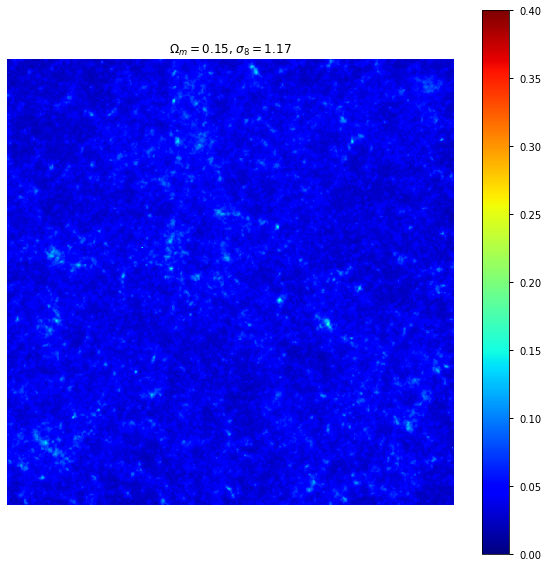

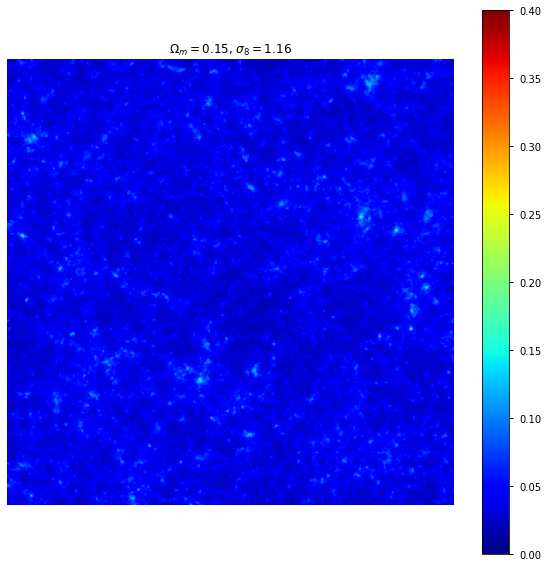

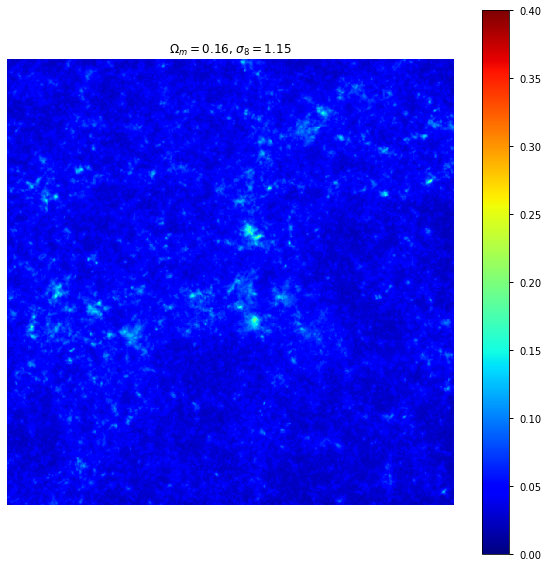

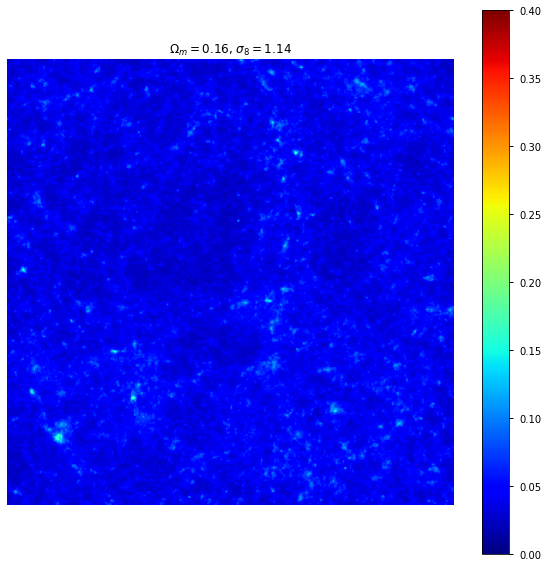

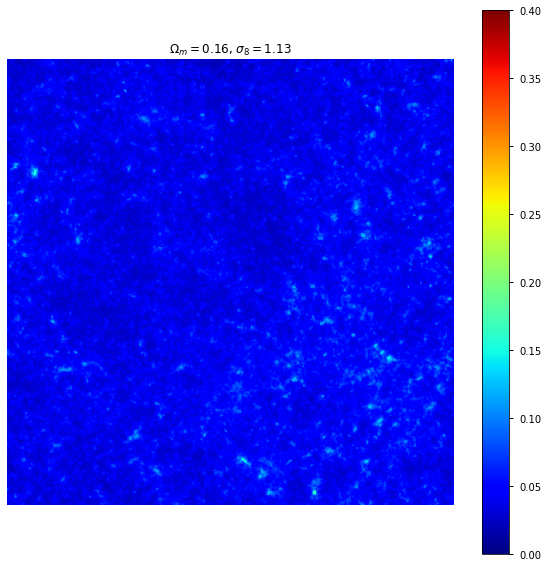

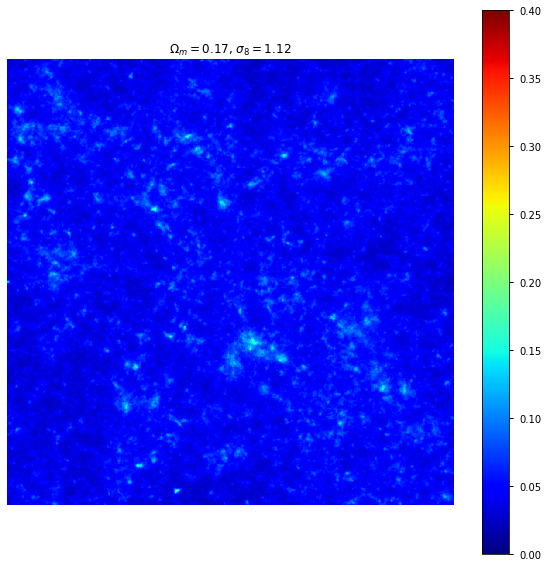

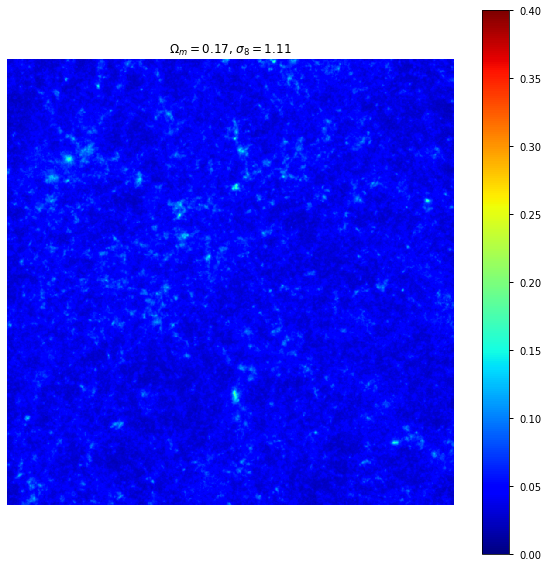

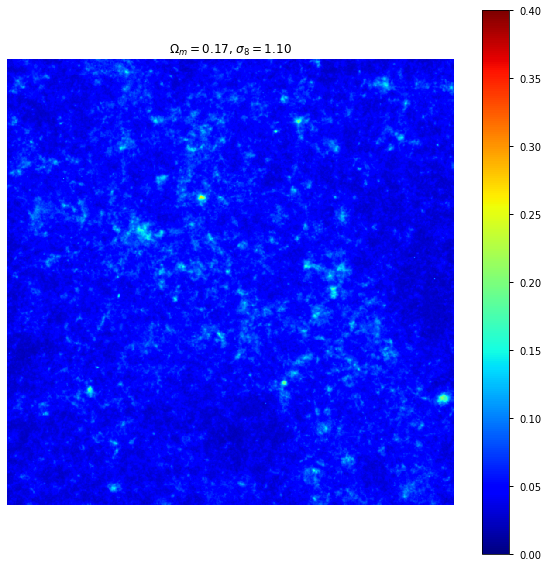

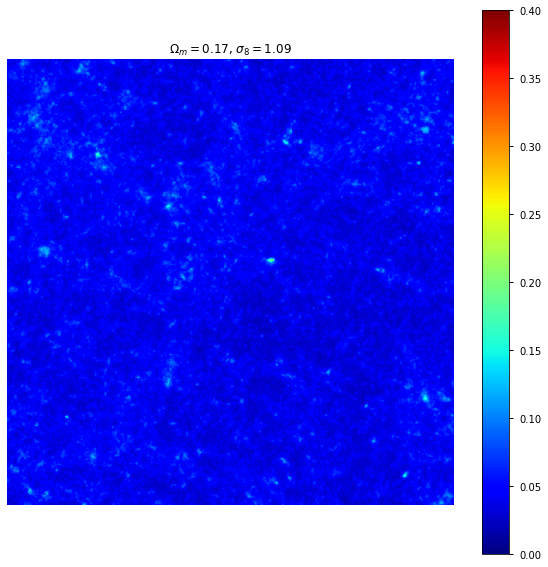

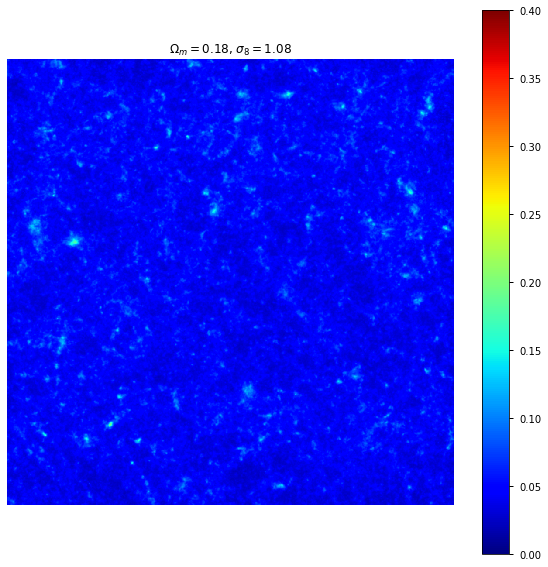

In [33]:
for ii in range(len(Omega_ms))[0:10]:
    plt.figure(figsize=(10,10))
    plt.title('$\Omega_m=%.2f$, $\sigma_8=%.2f$'%(Omega_ms[ii],sigma8s[ii]))
    plt.imshow(my_cropped_maps[ii],cmap='jet',vmin=0, vmax=0.4)
    plt.colorbar()
    plt.axis('off')
plt.show()

In [24]:
1/256./1e-3

3.90625

In [29]:
, Planck15.sigma8


0.8158116144901115